# Business Problem
Freedom Insurance Company (FIC) is an international insurance provider based out of the U.S. FIC has
historically focused on commercial insurance which is provided to businesses, however it also offers personal
insurance to individuals. The personal insurance branch of FIC has hired a new division president and she
wants to double FIC’s personal insurance business in the next five years. In order to accomplish this goal, FIC
has focused its budget on expanding its personal insurance product line, leaving limited marketing and
advertising budget.

One of the new offerings is a line of mobile home insurance products. With limited advertising resources, the
marketing team at FIC wants to understand __what types of customers are more likely to purchase mobile home
insurance__ so that they can reach out to the potential customers more efficiently and effectively. They have
gathered data on __8,000 customers with demographic information as well as their usage of various insurance
products__.

Review the data file provided and use it to address the following topics or questions. Please document your
code and analysis. RMarkdown or Jupyter notebooks are preferred (exported as HTML). Standard PDF
documents generated via latex or other methods are also acceptable. Note: We strongly recommend you keep
your document under 20 pages. It is important to note that you will be evaluated more heavily on your ability to
be concise with your analysis over nominal gains in model accuracy. You will need to bring and be able to
discuss:

1. Exploratory Data Analysis (EDA) and Feature Engineering\
    a. Provide a summary of the dataset. Note its dimensions and summarize the variable types
    within. Note any interesting discoveries you make as you explore the dataset.\
    b. Provide 2-3 visual artifacts that capture the most important relationships you find among the
    variables.
    
2. Model Building and Evaluation\
    a. Produce a model that predicts what kind of customer is likely to buy mobile home insurance and
    outline with notes and visuals on its performance.
    
3. Result Interpretation and Business Recommendation\
    a. Based on the model you produced, note what conclusions you make around which type of
    customer is more likely to buy mobile home insurance.

Make sure to note all calculations, any assumptions you make, and be prepared to justify your transformations,
model build, and criteria for success. During your on-site interview, you will be asked to walk-through the
resulting document. Please come prepared to discuss the following:
* Any characteristics of the data you are concerned about and how you addressed them.
* How you derived features for modeling. If you transformed any variables, discuss why.
* What criteria do you consider when selecting features for a model?
* The steps you took to build the model and reasoning behind those steps.
* Criteria used to gauge model performance.
* How you would address missing data when the model is applied to potential new customers.
* Conclusions you made around which type of customer is more likely to buy mobile home insurance.
* Your business recommendation and expected impact of your recommendation.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary


def plot_by_group(df, x_val, y_val, ):
    
    plt.figure(figsize=(16,6))

    g = sns.countplot(x=x_val, data=df, hue='mobile_home_policy')
    g.set_title("Mobile home policy \n# 0: Not enrolled | 1: Enrolled #", fontsize=22)
    g.set_xlabel("Customer main type", fontsize=18)
    g.set_ylabel('Count', fontsize=18)

    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 

    plt.show()

In [3]:
df = pd.read_csv('Coding Exercise Dataset.csv')
df.head()

,num_houses,avg_hh_size,avg_age,customer_maintype,relation_married,relation_living,relation_other,hh_singles,hh_no_child,hh_with_child,...,num_prvt_accid,num_fmly_accid,num_disability,num_fire,num_surfbrd,num_boat,num_bike,num_property,num_ss,mobile_home_policy
0,1,2,4,C,4,1,4,4,2,4,...,0,0,0,0,0,0,0,0,0,0
1,1,2,2,I,6,0,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0
2,1,4,3,I,7,1,2,1,1,8,...,0,0,0,1,0,0,1,0,0,1
3,1,2,4,A,5,0,4,3,4,3,...,0,0,0,0,0,0,0,0,0,0
4,1,2,2,E,4,1,4,4,4,2,...,0,0,0,1,0,0,0,0,0,0


In [4]:
print(f'Data dimesion:{df.shape}')
print(f'Data has')

Data dimesion:(8000, 81)
Data has


# Known the Target

* Distribution

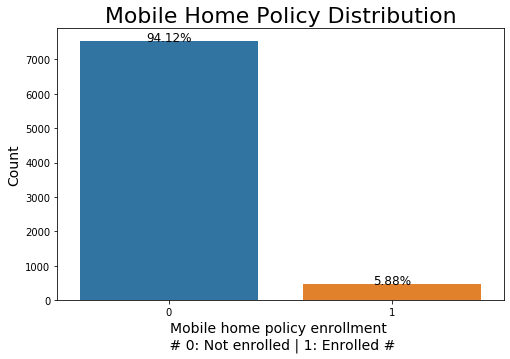

In [5]:
total=df.shape[0]
plt.figure(figsize=(8,5))

g = sns.countplot(x='mobile_home_policy', data=df)
g.set_title("Mobile Home Policy Distribution", fontsize=22)
g.set_xlabel("Mobile home policy enrollment \n # 0: Not enrolled | 1: Enrolled #", fontsize=14)
g.set_ylabel('Count', fontsize=14)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

plt.show()

We have 5.88% of mobile home policy enrollment in our dataset, which is highly imbalanced. Since the total number of observations is only 8000, in the modeling stage, __oversampling__ minor class might required.

# Known the Demographic Features

posx and posy should be finite values
posx and posy should be finite values


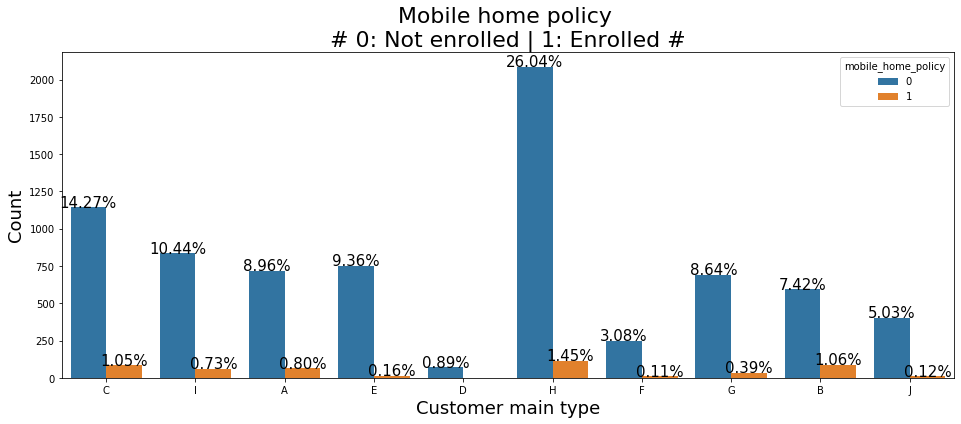

In [6]:
plt.figure(figsize=(16,6))

g = sns.countplot(x='customer_maintype', data=df, hue='mobile_home_policy')
g.set_title("Mobile home policy \n# 0: Not enrolled | 1: Enrolled #", fontsize=22)
g.set_xlabel("Customer main type", fontsize=18)
g.set_ylabel('Count', fontsize=18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

plt.show()

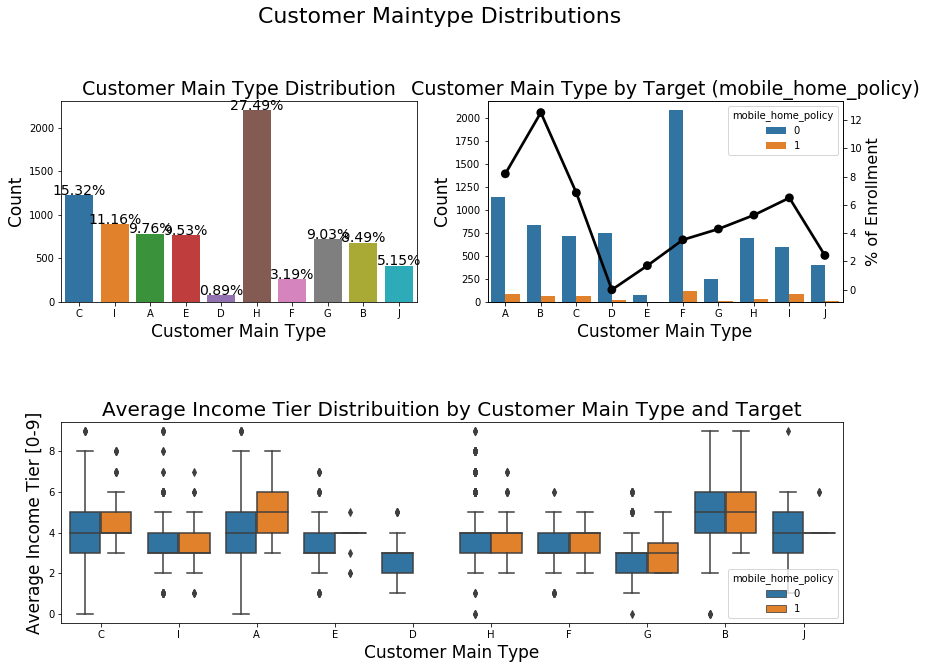

In [11]:
tmp = pd.crosstab(df['customer_maintype'], df['mobile_home_policy'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'Not Enrolled', 1:'Enrolled'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Customer Maintype Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='customer_maintype', data=df)
g.set_title("Customer Main Type Distribution", fontsize=19)
g.set_xlabel("Customer Main Type", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    

plt.subplot(222)
g1 = sns.countplot(x='customer_maintype', hue='mobile_home_policy', data=df)
gt = g1.twinx()
gt = sns.pointplot(x='customer_maintype', y='Enrolled', data=tmp, color='black', legend=False)
gt.set_ylabel("% of Enrollment", fontsize=16)
g1.set_title("Customer Main Type by Target (mobile_home_policy)", fontsize=19)
g1.set_xlabel("Customer Main Type", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxplot(x='customer_maintype', y='avg_income', hue='mobile_home_policy', 
              data=df)
g3.set_title("Average Income Tier Distribuition by Customer Main Type and Target", fontsize=20)
g3.set_xlabel("Customer Main Type", fontsize=17)
g3.set_ylabel("Average Income Tier [0-9]", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

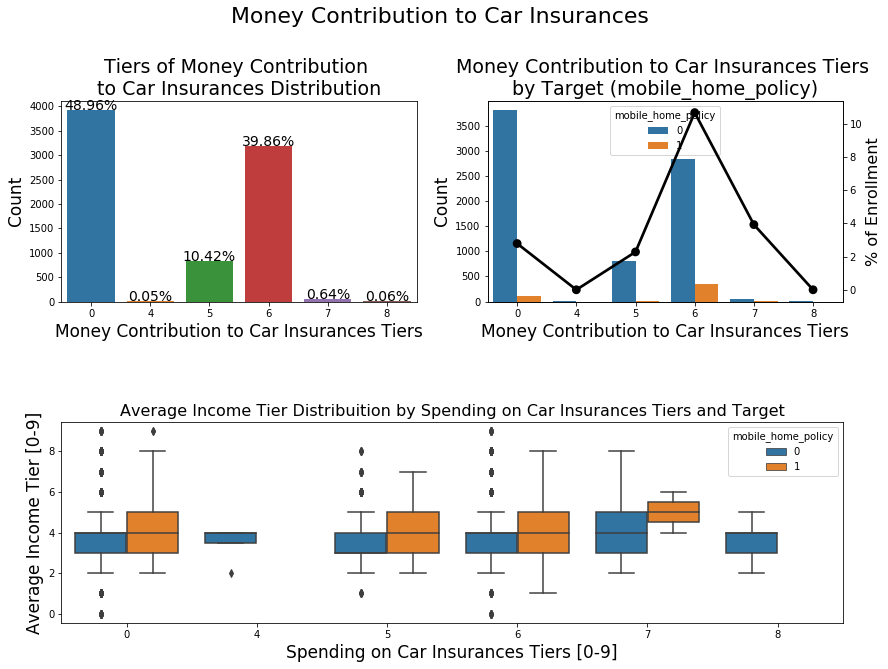

In [18]:
tmp = pd.crosstab(df['contrib_car'], df['mobile_home_policy'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'Not Enrolled', 1:'Enrolled'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Money Contribution to Car Insurances', fontsize=22)


plt.subplot(221)
g = sns.countplot(x='contrib_car', data=df)
g.set_title("Tiers of Money Contribution \nto Car Insurances Distribution", fontsize=19)
g.set_xlabel("Money Contribution to Car Insurances Tiers", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    

plt.subplot(222)
g1 = sns.countplot(x='contrib_car', hue='mobile_home_policy', data=df)
gt = g1.twinx()
gt = sns.pointplot(x='contrib_car', y='Enrolled', data=tmp, color='black', legend=False)
gt.set_ylabel("% of Enrollment", fontsize=16)
g1.set_title("Money Contribution to Car Insurances Tiers \nby Target (mobile_home_policy)", fontsize=19)
g1.set_xlabel("Money Contribution to Car Insurances Tiers", fontsize=17)
g1.set_ylabel("Count", fontsize=17)


plt.subplot(212)
g3 = sns.boxplot(x='contrib_car', y='avg_income', hue='mobile_home_policy', data=df)
g3.set_title("Average Income Tier Distribuition by Spending on Car Insurances Tiers and Target", fontsize=16)
g3.set_xlabel("Spending on Car Insurances Tiers [0-9]", fontsize=17)
g3.set_ylabel("Average Income Tier [0-9]", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

According to the importance ranking, I selected the top four features to interpret their association with mobile home insurance enrollment. To assist my analysis, I used two boxplots. From the first boxplot, the distribution of average income tiers is separated by not enrolled (0: yellow) and enrolled (1: blue), and grouped by the spendings on car insurance. As the data shows, customers with the car insurance spending fell in tier 4 and 8 have no mobile home policy enrollment. This suggests that people who spent a quite small amount of money (200-499) or much more money (above 10000) tend to choose not purchasing mobile home insurance. This is reasonable since 1) the people with a cheap car insurance policy are more likely to rent apartment or condo so that they don't need to consider purchase mobile home insurance, and 2) the people spent lots of money on car insurances are mostly rich so they don't live in the mobile home either.  
Within the customer group that spends 5000-9999 dollars in car insurance, those customers living in the neighborhood of average income class between 5th and 6th were showing the tendency to purchase mobile home insurance. On the other hand, the customers in the zip code of average income class between 3rd to 5th are more likely to be without mobile home insurance. For those people who have no car or the people who spent (500-4999) dollars on car insurance, the low-income zip code group also tends to stay without mobile home insurance.

# preprocessing

In [8]:
# extract all the numeric cols
import re
num_cols = [re.findall(r'num_.*', i)[0] for i in df.columns if re.match(r'num_.*', i)]
[num_cols.append(i) for i in ['avg_hh_size']]
print(num_cols)
print(len(num_cols))

['num_houses', 'num_prvt_3rd_prt', 'num_3rd_prt_firm', 'num_3rd_prt_agri', 'num_car', 'num_deliv_van', 'num_scooter', 'num_lorry', 'num_trailer', 'num_tractor', 'num_agri_machine', 'num_moped', 'num_life', 'num_prvt_accid', 'num_fmly_accid', 'num_disability', 'num_fire', 'num_surfbrd', 'num_boat', 'num_bike', 'num_property', 'num_ss', 'avg_hh_size']
23


In [39]:
# Label Encoding
drop_cols= num_cols.copy()
drop_cols.append('mobile_home_policy')

df_cat = df.drop(drop_cols, axis=1)
df_cat = df_cat.astype('object')

for f in df_cat.columns:
    if df_cat[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_cat[f].values))
        df_cat[f] = lbl.transform(list(df_cat[f].values))
        
print(df_cat.shape)

df_preprocessed = pd.concat([df_cat, df[num_cols], df['mobile_home_policy']], axis=1)
df_preprocessed.head()

(8000, 57)


,avg_age,customer_maintype,relation_married,relation_living,relation_other,hh_singles,hh_no_child,hh_with_child,education_high,education_medium,...,num_fmly_accid,num_disability,num_fire,num_surfbrd,num_boat,num_bike,num_property,num_ss,avg_hh_size,mobile_home_policy
0,3,2,4,1,4,4,2,4,1,4,...,0,0,0,0,0,0,0,0,2,0
1,1,8,6,0,3,3,3,4,0,1,...,0,0,0,0,0,0,0,0,2,0
2,2,8,7,1,2,1,1,8,0,2,...,0,0,1,0,0,1,0,0,4,1
3,3,0,5,0,4,3,4,3,2,5,...,0,0,0,0,0,0,0,0,2,0
4,1,4,4,1,4,4,4,2,2,4,...,0,0,1,0,0,0,0,0,2,0


In [10]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    
    return df

df_preprocessed = PCA_change(df_preprocessed, num_cols, prefix='PCA_V', n_components=10)
df_preprocessed.head()

,avg_age,customer_maintype,relation_married,relation_living,relation_other,hh_singles,hh_no_child,hh_with_child,education_high,education_medium,...,PCA_V0,PCA_V1,PCA_V2,PCA_V3,PCA_V4,PCA_V5,PCA_V6,PCA_V7,PCA_V8,PCA_V9
0,3,2,4,1,4,4,2,4,1,4,...,-0.646763,-0.435528,0.738171,-0.078359,-0.023484,-0.004308,-0.094854,-0.016489,-0.063577,-0.038164
1,1,8,6,0,3,3,3,4,0,1,...,-0.646763,-0.435528,0.738171,-0.078359,-0.023484,-0.004308,-0.094854,-0.016489,-0.063577,-0.038164
2,2,8,7,1,2,1,1,8,0,2,...,1.280299,0.377364,-0.844518,-0.104942,-0.009524,-0.348148,-0.143221,0.062986,-0.009799,0.956119
3,3,0,5,0,4,3,4,3,2,5,...,-0.646763,-0.435528,0.738171,-0.078359,-0.023484,-0.004308,-0.094854,-0.016489,-0.063577,-0.038164
4,1,4,4,1,4,4,4,2,2,4,...,-0.716518,0.389638,-0.753996,-0.118122,-0.004326,-0.276582,-0.043855,0.066341,-0.027742,-0.037882


# Let's do some modeling
* oversampling based on SMOTE

In [40]:
from sklearn.model_selection import train_test_split

# split dataset
x = df_preprocessed.drop('mobile_home_policy',axis=1)
y = df_preprocessed.mobile_home_policy
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=100, stratify=y)
# Print the shapes of X & Y
print(x_train.shape)
print(y_train.shape)

(5600, 80)
(5600,)


In [41]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek(random_state=42)
x_re, y_re = smk.fit_sample(x_train, y_train)
print(x_re.shape, y_re.shape)
x_re.head()

(10410, 80) (10410,)


,avg_age,customer_maintype,relation_married,relation_living,relation_other,hh_singles,hh_no_child,hh_with_child,education_high,education_medium,...,num_prvt_accid,num_fmly_accid,num_disability,num_fire,num_surfbrd,num_boat,num_bike,num_property,num_ss,avg_hh_size
0,2,1,6,1,2,2,3,4,3,4,...,0,0,0,1,0,0,0,0,0,3
1,1,9,6,3,0,0,5,4,1,7,...,0,0,0,1,0,0,0,0,0,3
2,1,4,1,2,6,3,5,1,2,6,...,0,0,0,0,0,0,0,0,0,2
3,1,0,7,1,2,2,4,4,5,4,...,0,0,0,1,0,0,0,0,0,4
4,2,9,6,0,3,2,3,5,1,2,...,0,0,0,1,0,0,0,0,0,3


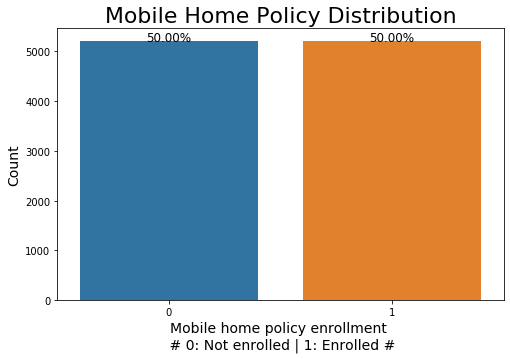

In [42]:
total=y_re.shape[0]
plt.figure(figsize=(8,5))

g = sns.countplot(x=y_re)
g.set_title("Mobile Home Policy Distribution", fontsize=22)
g.set_xlabel("Mobile home policy enrollment \n # 0: Not enrolled | 1: Enrolled #", fontsize=14)
g.set_ylabel('Count', fontsize=14)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

plt.show()

In [43]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
import time

def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
        'n_estimators':int(params['n_estimators'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 10
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    # tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(x_test.shape[0])
    y_oof = np.zeros(x_re.shape[0])
    score_mean = 0
    
    for tr_idx, val_idx in skf.split(x_re, y_re):
        
        X_tr, X_vl = x_re.iloc[tr_idx, :], x_re.iloc[val_idx, :]
        y_tr, y_vl = y_re.iloc[tr_idx], y_re.iloc[val_idx]
        
        scale_weight = sum(y_tr==0) / sum(y_tr==1)
        
        clf = xgb.XGBClassifier(
            random_state=1104, verbose=True, 
            tree_method='gpu_hist', scale_pos_weight=scale_weight,
            **params
        )

        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        #print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean recall_score: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # randomly number of trees.
    'n_estimators': 40,
    'max_depth': hp.quniform('max_depth', 2, 4, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.5),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .5),
    'learning_rate': 0.05,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .9),
    'num_leaves': hp.choice('num_leaves', list(range(10, 300, 5))),
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 350, 20))),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9),

}

In [44]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

                                                      
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.422', 'subsample': '0.80', 'reg_alpha': '0.079', 'reg_lambda': '0.379', 'learning_rate': '0.050', 'num_leaves': '160.000', 'colsample_bytree': '0.680', 'min_child_samples': '220.000', 'feature_fraction': '0.756', 'bagging_fraction': '0.489', 'n_estimators': 40}
Total Time Run: 0.02                                  
Mean recall_score: 0.7521633692602983                 
                                                                                 
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.871', 'subsample': '0.90', 'reg_alpha': '0.167', 'reg_lambda': '0.248', 'learning_rate': '0.050', 'num_leaves': '105.000', 'colsample_bytree': '0.352', 'min_child_samples': '340.000', 'feature_fraction': '0.659', 'bagging_fraction': '0.527', 'n_estimators': 40}
Total Time Run: 0.02                                                     

In [45]:
# Print best parameters
best_params = space_eval(space, best)

print("BEST PARAMS: ", best_params)

best_params['max_depth'] = int(best_params['max_depth'])

BEST PARAMS:  {'bagging_fraction': 0.6817025172820845, 'colsample_bytree': 0.8778623329125109, 'feature_fraction': 0.5940167290930692, 'gamma': 0.5750065465007418, 'learning_rate': 0.05, 'max_depth': 4.0, 'min_child_samples': 280, 'n_estimators': 40, 'num_leaves': 30, 'reg_alpha': 0.024919725033919315, 'reg_lambda': 0.08405442443118002, 'subsample': 0.2}


In [46]:
clf = xgb.XGBClassifier(
    **best_params,
    tree_method='gpu_hist'
)

clf.fit(x_re, y_re)

XGBClassifier(bagging_fraction=0.6817025172820845, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8778623329125109,
              feature_fraction=0.5940167290930692, gamma=0.5750065465007418,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_samples=280, min_child_weight=1, missing=None,
              n_estimators=40, n_jobs=1, nthread=None, num_leaves=30,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.024919725033919315, reg_lambda=0.08405442443118002,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.2,
              tree_method='gpu_hist', verbosity=1)

In [47]:
y_preds = clf.predict(x_test)

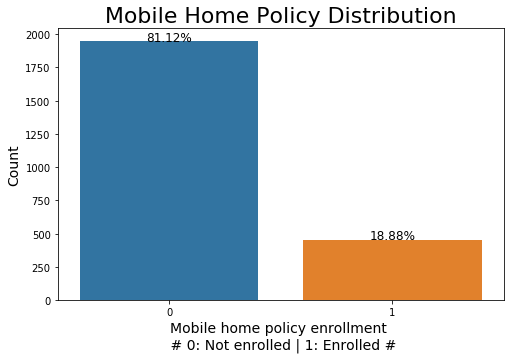

In [48]:
total=y_preds.shape[0]
plt.figure(figsize=(8,5))

g = sns.countplot(x=y_preds)
g.set_title("Mobile Home Policy Distribution", fontsize=22)
g.set_xlabel("Mobile home policy enrollment \n # 0: Not enrolled | 1: Enrolled #", fontsize=14)
g.set_ylabel('Count', fontsize=14)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

plt.show()

In [49]:
y_preds = clf.predict_proba(x_test)[:,1] 
y_preds = np.array(y_preds)
# y_preds[y_preds > 0.5] = 1
y_preds[y_preds > 0.03] = 1
y_preds[y_preds != 1] = 0
y_preds

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [50]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix

print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

0.05875
0.11097992916174733
1.0
0.5


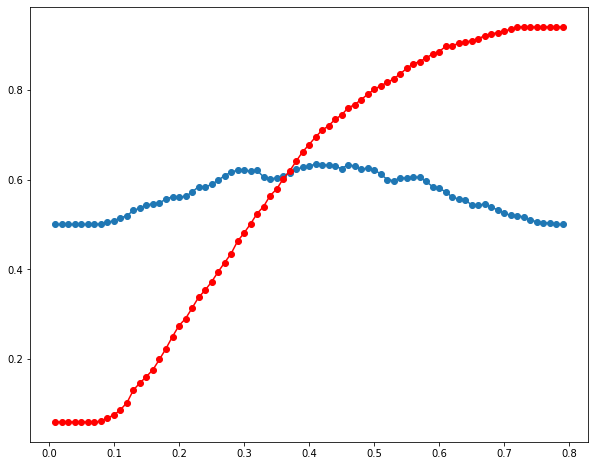

In [51]:
thresheds = np.arange(0.01, 0.8, 0.01)
roc_auc_scores = []
accuracy_scores = []

for i in thresheds:
    
    y_preds = clf.predict_proba(x_test)[:,1] 
    y_preds = np.array(y_preds)
    # y_preds[y_preds > 0.5] = 1
    y_preds[y_preds > i] = 1
    y_preds[y_preds != 1] = 0
    
    roc_auc_scores.append(roc_auc_score(y_test, y_preds))
    accuracy_scores.append(accuracy_score(y_test, y_preds))

plt.figure(figsize=(10,8))
plt.plot(thresheds, roc_auc_scores, 'o-')
plt.plot(thresheds, accuracy_scores, 'o-', color='red')
plt.show()

In [52]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
income_grp_1,37
contrib_car,37
cars_none,23
education_low,22
relation_other,21
contrib_fire,19
income_grp_2,19
cars_two,18
purchase_pwr_cls,18
num_car,17


In [55]:
def objective_origin(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
        'n_estimators':int(params['n_estimators'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 10
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    # tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(x_test.shape[0])
    y_oof = np.zeros(x_train.shape[0])
    score_mean = 0
    
    for tr_idx, val_idx in skf.split(x_train, y_train):
        
        X_tr, X_vl = x_train.iloc[tr_idx, :], x_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        scale_weight = sum(y_tr==0) / sum(y_tr==1)
        
        clf = xgb.XGBClassifier(
            random_state=1104, verbose=True, 
            tree_method='gpu_hist', scale_pos_weight=scale_weight,
            **params
        )

        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        #print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean recall_score: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # randomly number of trees.
    'n_estimators': 40,
    'max_depth': hp.quniform('max_depth', 2, 4, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.5),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .5),
    'learning_rate': 0.05,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .9),
    'num_leaves': hp.choice('num_leaves', list(range(10, 300, 5))),
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 350, 20))),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9),

}


In [56]:
# Set algoritm parameters
best = fmin(fn=objective_origin,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

                                                      
############## New Run ################
params = {'max_depth': 3, 'gamma': '0.600', 'subsample': '0.60', 'reg_alpha': '0.060', 'reg_lambda': '0.381', 'learning_rate': '0.050', 'num_leaves': '235.000', 'colsample_bytree': '0.321', 'min_child_samples': '160.000', 'feature_fraction': '0.476', 'bagging_fraction': '0.788', 'n_estimators': 40}
Total Time Run: 0.02                                  
Mean recall_score: 0.6907789948824103                 
                                                                                 
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.249', 'subsample': '0.90', 'reg_alpha': '0.339', 'reg_lambda': '0.354', 'learning_rate': '0.050', 'num_leaves': '240.000', 'colsample_bytree': '0.517', 'min_child_samples': '200.000', 'feature_fraction': '0.629', 'bagging_fraction': '0.671', 'n_estimators': 40}
Total Time Run: 0.02                                                     

Mean recall_score: 0.6939791055718476                                             
                                                                                  
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.670', 'subsample': '0.50', 'reg_alpha': '0.216', 'reg_lambda': '0.497', 'learning_rate': '0.050', 'num_leaves': '160.000', 'colsample_bytree': '0.361', 'min_child_samples': '280.000', 'feature_fraction': '0.720', 'bagging_fraction': '0.834', 'n_estimators': 40}
Total Time Run: 0.02                                                              
Mean recall_score: 0.6941684995112415                                             
                                                                                  
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.800', 'subsample': '0.50', 'reg_alpha': '0.120', 'reg_lambda': '0.482', 'learning_rate': '0.050', 'num_leaves': '160.000', 'colsample_bytree': '0.562', 'min_child_samp

In [57]:
# Print best parameters
best_params = space_eval(space, best)

print("BEST PARAMS: ", best_params)

best_params['max_depth'] = int(best_params['max_depth'])

scale_weight = sum(y_train == 0) / sum(y_train == 1)

clf = xgb.XGBClassifier(
    scale_pos_weight=scale_weight,
    **best_params,
    tree_method='gpu_hist'
)

clf.fit(x_train, y_train)

BEST PARAMS:  {'bagging_fraction': 0.7872320911352968, 'colsample_bytree': 0.3200647943005808, 'feature_fraction': 0.7768949812070401, 'gamma': 0.6983876180940516, 'learning_rate': 0.05, 'max_depth': 2.0, 'min_child_samples': 180, 'n_estimators': 40, 'num_leaves': 140, 'reg_alpha': 0.3374282369040257, 'reg_lambda': 0.010841944530755548, 'subsample': 0.6}


In [58]:
y_preds = clf.predict(x_test)
print(accuracy_score(y_test, y_preds))
print(f1_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

0.7029166666666666
0.2015677491601344
0.6382978723404256
0.6726239251033691


In [59]:
clf.predict_proba(x_test)

array([[0.4206313 , 0.5793687 ],
       [0.6144074 , 0.3855926 ],
       [0.8128011 , 0.18719885],
       ...,
       [0.5669444 , 0.43305558],
       [0.5164412 , 0.4835588 ],
       [0.6430459 , 0.3569541 ]], dtype=float32)

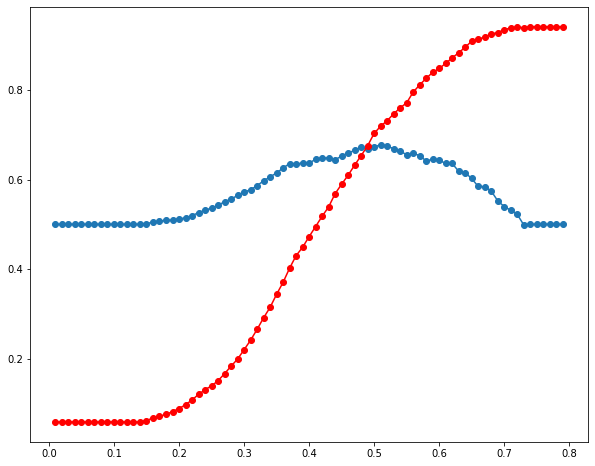

In [60]:
thresheds = np.arange(0.01, 0.8, 0.01)
roc_auc_scores = []
accuracy_scores = []

for i in thresheds:
    
    y_preds = clf.predict_proba(x_test)[:,1] 
    y_preds = np.array(y_preds)
    # y_preds[y_preds > 0.5] = 1
    y_preds[y_preds > i] = 1
    y_preds[y_preds != 1] = 0
    
    roc_auc_scores.append(roc_auc_score(y_test, y_preds))
    accuracy_scores.append(accuracy_score(y_test, y_preds))

plt.figure(figsize=(10,8))
plt.plot(thresheds, roc_auc_scores, 'o-')
plt.plot(thresheds, accuracy_scores, 'o-', color='red')
plt.show()

# Feature transformations with ensembles of trees

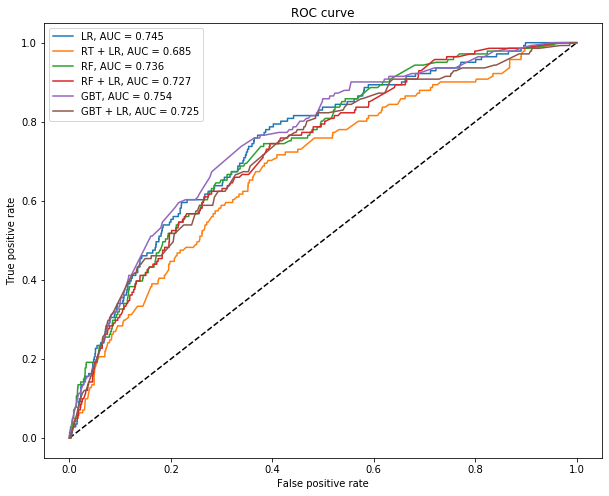

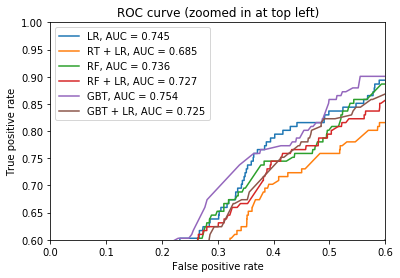

In [122]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
x_train0, x_test, y_train0, y_test = train_test_split(x, y, train_size=0.7, random_state=2020, stratify=y)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
x_train, x_train_lr, y_train, y_train_lr = train_test_split(
    x_train0, y_train0, test_size=0.25, stratify=y_train0, random_state=1000)


# Logistic regression only
lm = LogisticRegression(max_iter=1000)
lm.fit(x_train0, y_train0)
y_pred_lm = lm.predict_proba(x_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)
auc_lm =roc_auc_score(y_test, y_pred_lm)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
                          random_state=0)

rt_lm = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(x_train, y_train)
y_pred_rt = pipeline.predict_proba(x_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_rt_lm =roc_auc_score(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)
rf.fit(x_train, y_train)
rf_enc.fit(rf.apply(x_train))
rf_lm.fit(rf_enc.transform(rf.apply(x_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(x_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm =roc_auc_score(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)
grd.fit(x_train, y_train)
grd_enc.fit(grd.apply(x_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(x_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(x_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm =roc_auc_score(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd =roc_auc_score(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf =roc_auc_score(y_test, y_pred_rf)

plt.figure(figsize=(10,8))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label=f'LR, AUC = {round(auc_lm,3)}')
plt.plot(fpr_rt_lm, tpr_rt_lm, label=f'RT + LR, AUC = {round(auc_rt_lm,3)}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {round(auc_rf,3)}')
plt.plot(fpr_rf_lm, tpr_rf_lm, label=f'RF + LR, AUC = {round(auc_rf_lm,3)}')
plt.plot(fpr_grd, tpr_grd, label=f'GBT, AUC = {round(auc_grd,3)}')
plt.plot(fpr_grd_lm, tpr_grd_lm, label=f'GBT + LR, AUC = {round(auc_grd_lm,3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.6)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label=f'LR, AUC = {round(auc_lm,3)}')
plt.plot(fpr_rt_lm, tpr_rt_lm, label=f'RT + LR, AUC = {round(auc_rt_lm,3)}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {round(auc_rf,3)}')
plt.plot(fpr_rf_lm, tpr_rf_lm, label=f'RF + LR, AUC = {round(auc_rf_lm,3)}')
plt.plot(fpr_grd, tpr_grd, label=f'GBT, AUC = {round(auc_grd,3)}')
plt.plot(fpr_grd_lm, tpr_grd_lm, label=f'GBT + LR, AUC = {round(auc_grd_lm,3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

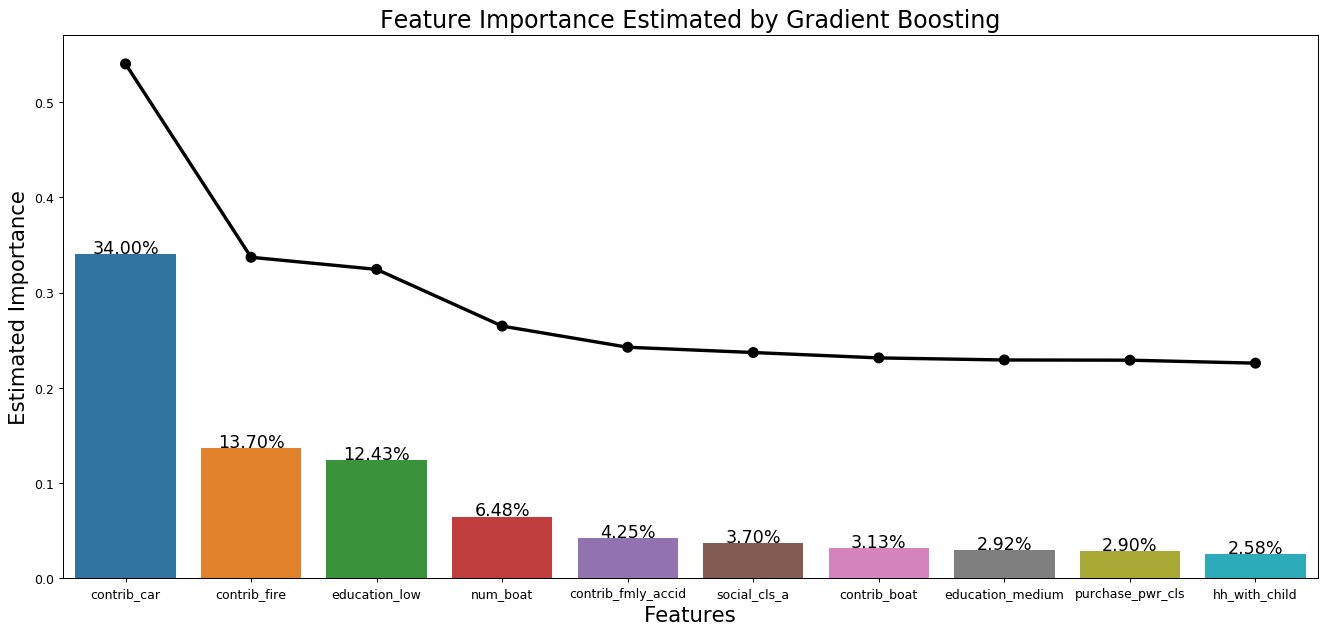

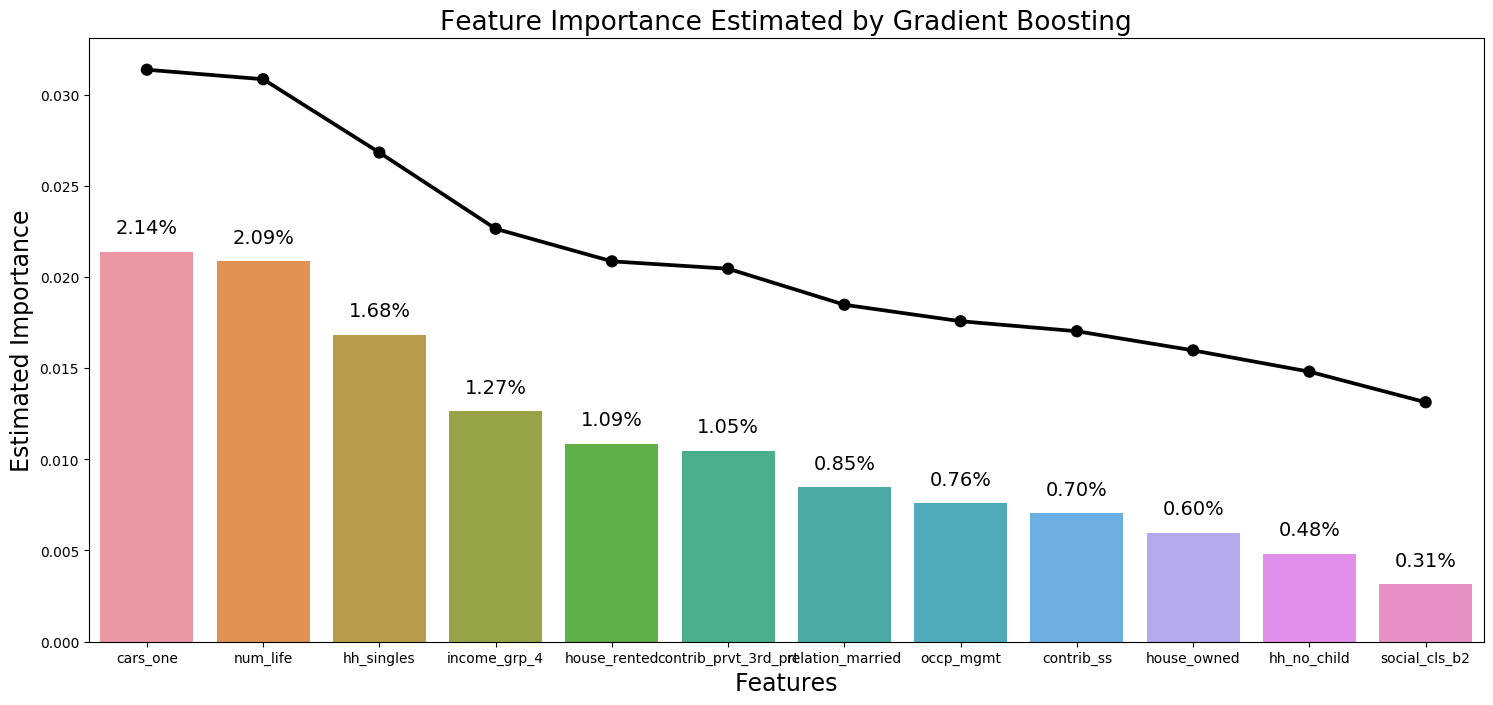

In [176]:
feature_important = grd.feature_importances_
keys = x_train.columns.tolist()
data = pd.DataFrame(data=zip(keys, feature_important), columns=["feature",'score'])
data = data.sort_values(by = "score", ascending=False)
data = data.set_index(np.arange(80))

plt.figure(1,figsize=(18,8), dpi = 90)
g = sns.barplot("feature", "score", data=data.head(10))
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 0.001,
            '{:1.2f}%'.format(height*100),
            ha="center", fontsize=14) 

gt = sns.pointplot(x=data.head(10).feature, y=data.head(10).score + 0.2, data=data.head(10), color='black', legend=False)
gt.set_ylabel("% of Enrollment", fontsize=16)
g.set_title("Feature Importance Estimated by Gradient Boosting", fontsize=19)
g.set_xlabel("Features", fontsize=17)
g.set_ylabel("Estimated Importance", fontsize=17)
    
plt.show()


plt.figure(2,figsize=(18,8), dpi = 100)
g = sns.barplot("feature", "score", data=data.loc[10:21,:])
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 0.001,
            '{:1.2f}%'.format(height*100),
            ha="center", fontsize=14) 

gt = sns.pointplot(x=data.loc[10:21,:].feature, y=data.loc[10:21,:].score + 0.01, color='black', legend=False)
gt.set_ylabel("% of Enrollment", fontsize=16)
g.set_title("Feature Importance Estimated by Gradient Boosting", fontsize=19)
g.set_xlabel("Features", fontsize=17)
g.set_ylabel("Estimated Importance", fontsize=17)
    
plt.show()

In [184]:
feature_20 = data.loc[:19,:].feature.tolist()
x_20 = x[feature_20]
x_20.head()

,contrib_car,contrib_fire,education_low,num_boat,contrib_fmly_accid,social_cls_a,contrib_boat,education_medium,purchase_pwr_cls,hh_with_child,cars_one,num_life,hh_singles,income_grp_4,house_rented,contrib_prvt_3rd_prt,relation_married,occp_mgmt,contrib_ss,house_owned
0,3,0,4,0,0,1,0,4,3,4,5,0,4,0,9,0,4,5,0,0
1,3,0,8,0,0,0,0,1,3,4,5,0,3,0,9,0,6,4,0,0
2,0,3,7,0,0,1,0,2,4,8,6,0,1,0,6,2,7,1,0,3
3,3,0,3,0,0,5,0,5,5,3,7,0,3,0,4,0,5,2,0,5
4,0,1,4,0,0,3,0,4,1,2,6,0,4,0,7,2,4,3,0,2


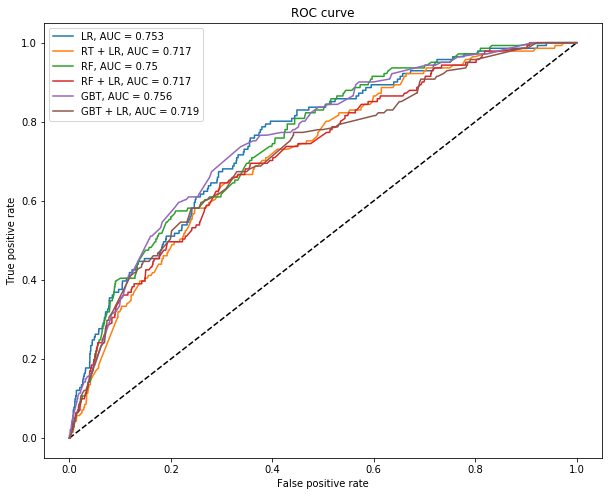

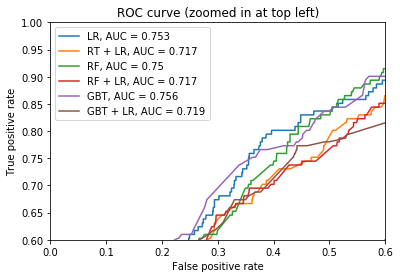

In [185]:
n_estimator = 10



x_train0, x_test, y_train0, y_test = train_test_split(x_20, y, train_size=0.7, random_state=2020, stratify=y)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
x_train, x_train_lr, y_train, y_train_lr = train_test_split(
    x_train0, y_train0, test_size=0.25, stratify=y_train0, random_state=1000)


# Logistic regression only
lm = LogisticRegression(max_iter=1000)
lm.fit(x_train0, y_train0)
y_pred_lm = lm.predict_proba(x_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)
auc_lm =roc_auc_score(y_test, y_pred_lm)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
                          random_state=0)

rt_lm = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(x_train, y_train)
y_pred_rt = pipeline.predict_proba(x_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_rt_lm =roc_auc_score(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)
rf.fit(x_train, y_train)
rf_enc.fit(rf.apply(x_train))
rf_lm.fit(rf_enc.transform(rf.apply(x_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(x_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm =roc_auc_score(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)
grd.fit(x_train, y_train)
grd_enc.fit(grd.apply(x_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(x_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(x_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm =roc_auc_score(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd =roc_auc_score(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf =roc_auc_score(y_test, y_pred_rf)

plt.figure(figsize=(10,8))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label=f'LR, AUC = {round(auc_lm,3)}')
plt.plot(fpr_rt_lm, tpr_rt_lm, label=f'RT + LR, AUC = {round(auc_rt_lm,3)}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {round(auc_rf,3)}')
plt.plot(fpr_rf_lm, tpr_rf_lm, label=f'RF + LR, AUC = {round(auc_rf_lm,3)}')
plt.plot(fpr_grd, tpr_grd, label=f'GBT, AUC = {round(auc_grd,3)}')
plt.plot(fpr_grd_lm, tpr_grd_lm, label=f'GBT + LR, AUC = {round(auc_grd_lm,3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.6)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label=f'LR, AUC = {round(auc_lm,3)}')
plt.plot(fpr_rt_lm, tpr_rt_lm, label=f'RT + LR, AUC = {round(auc_rt_lm,3)}')
plt.plot(fpr_rf, tpr_rf, label=f'RF, AUC = {round(auc_rf,3)}')
plt.plot(fpr_rf_lm, tpr_rf_lm, label=f'RF + LR, AUC = {round(auc_rf_lm,3)}')
plt.plot(fpr_grd, tpr_grd, label=f'GBT, AUC = {round(auc_grd,3)}')
plt.plot(fpr_grd_lm, tpr_grd_lm, label=f'GBT + LR, AUC = {round(auc_grd_lm,3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()